## Imports

In [281]:
import json
import os
import sys

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.initializers import RandomUniform, RandomNormal, HeNormal, GlorotUniform, Constant, Zeros
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2



dir_parts = os.getcwd().split(os.path.sep)
root_index = dir_parts.index('ML-B')
root_path = os.path.sep.join(dir_parts[:root_index + 1])
sys.path.append(root_path + '/code/')
from data.data_config import Dataset
from data.data_utils import load_monk, load_cup, store_monk_result, store_cup_result
from hyperparameter_tuning import grid_search, random_search, tuning_search_top_configs
from training.solver import Solver

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Neural Networks
In this notebook we implement and test a custom (feed-forward) Neural Network w.r.t. the tasks at hand, i.e. the three MONK's problem and the CUP dataset.

Specifically:
- **get_nn_classifier(...)**: defines the NN classifier for the MONK's problems;
- **get_nn_regressor(...)**: defines the NN regressor for the CUP dataset.

## Settings

In [282]:
MODEL_NAME = 'NN-ADAM'
INTERNAL_TEST_SPLIT = 0.1 # internal test split percentage
RANDOM_STATE = 128 # reproducibility
N_SPLITS = 5 # cross-validation

## Path

In [283]:
# Directories
results_dir = root_path + '/results/' + MODEL_NAME

# Filepaths (MONK)
m1_dev_path, m1_test_path = Dataset.MONK_1.dev_path, Dataset.MONK_1.test_path # MONK 1
m2_dev_path, m2_test_path = Dataset.MONK_2.dev_path, Dataset.MONK_2.test_path # MONK 2
m3_dev_path, m3_test_path = Dataset.MONK_3.dev_path, Dataset.MONK_3.test_path # MONK 3

# Filepaths (CUP)
cup_dev_path, cup_test_path = Dataset.CUP.dev_path, Dataset.CUP.test_path

# MONK-1

In [284]:
# Load MONK-1
x_dev_m1, y_dev_m1, x_test_m1, y_test_m1 = load_monk(m1_dev_path, m1_test_path)

## Model

In [285]:
def get_nn_classifier(hparams):
    initializer = GlorotUniform(seed=RANDOM_STATE) # Glorot (Xavier)
    
    model = Sequential([
        Dense(
            hparams['h_dim'], 
            activation='tanh', 
            input_shape=(17,), 
            kernel_initializer=initializer),
        Dense(1, activation='sigmoid', kernel_regularizer=l2(hparams['reg']))
    ])
    
    optimizer = Adam(learning_rate=hparams['lr'], beta_1=hparams['beta_1'], beta_2=hparams['beta_2'])
    model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
    
    model.hparams = hparams
    return model

## Training - Testing

In [ ]:
model_m1 = get_nn_classifier(hparams={'lr': 0.3, 'h_dim': 4, 'reg': 0, 'beta_1': 0.9, 'beta_2': 0.9})
solver = Solver(model_m1, x_dev_m1, y_dev_m1, x_test_m1, y_test_m1, target='loss')
solver.train(epochs=300, patience=None, batch_size=len(x_dev_m1))

In [ ]:
solver.plot_history(results_dir + '/MONK1/history', 'MSE', 'Accuracy')

In [20]:
print('-- DEVELOPMENT --')
acc_dev_m1, mse_dev_m1 = model_m1.evaluate(x_dev_m1, y_dev_m1)
print(f'Accuracy: {acc_dev_m1:.4f} - MSE: {mse_dev_m1:.4f}')

-- DEVELOPMENT --
4/4 [==============================] - 0s 2ms/step - loss: 4.2429e-08 - accuracy: 1.0000 - mse: 2.2413e-15
Loss (BCE): 0.0000 - Accuracy: 1.0000 - MSE: 0.0000


In [21]:
print('-- TEST --')
acc_test_m1, mse_test_m1 = model_m1.evaluate(x_test_m1, y_test_m1)
print(f'Accuracy: {acc_test_m1:.4f} - MSE: {mse_test_m1:.4f}')

-- TEST --
14/14 [==============================] - 0s 2ms/step - loss: 6.5249e-08 - accuracy: 1.0000 - mse: 2.2121e-13
Loss (BCE): 0.0000 - Accuracy: 1.0000 - MSE: 0.0000


## Store results

In [22]:
report_m1 = {
    'dev': {'accuracy': acc_dev_m1, 'mse': mse_dev_m1},
    'test': {'accuracy': acc_test_m1, 'mse': mse_test_m1}
}

store_monk_result(results_dir + '/MONK1/', model_m1.hparams, report_m1)

# MONK-2

In [24]:
# Load MONK-2
x_dev_m2, y_dev_m2, x_test_m2, y_test_m2 = load_monk(m2_dev_path, m2_test_path)

## Training - Testing

In [ ]:
model_m2 = get_nn_classifier(hparams={'lr': 0.3, 'h_dim': 4, 'reg': 0, 'beta_1': 0.9, 'beta_2': 0.9})
solver = Solver(model_m2, x_dev_m2, y_dev_m2, target='loss')
solver.train(epochs=300, patience=None, batch_size=len(x_dev_m2))

In [ ]:
solver.plot_history(results_dir + '/MONK2/history', 'MSE', 'Accuracy')

In [26]:
print('-- DEVELOPMENT --')
acc_dev_m2, mse_dev_m2 = model_m2.evaluate(x_dev_m2, y_dev_m2)
print(f'Accuracy: {acc_dev_m2:.4f} - MSE: {mse_dev_m2:.4f}')

-- DEVELOPMENT --
6/6 [==============================] - 0s 3ms/step - loss: 2.9529e-06 - accuracy: 1.0000 - mse: 9.2162e-12
Loss (BCE): 0.0000 - Accuracy: 1.0000 - MSE: 0.0000


In [27]:
print('-- TEST --')
acc_test_m2, mse_test_m2 = model_m2.evaluate(x_test_m2, y_test_m2)
print(f'Accuracy: {acc_test_m2:.4f} - MSE: {mse_test_m2:.4f}')

-- TEST --
14/14 [==============================] - 0s 2ms/step - loss: 2.9677e-06 - accuracy: 1.0000 - mse: 9.6690e-12
Loss (BCE): 0.0000 - Accuracy: 1.0000 - MSE: 0.0000


## Store results

In [28]:
report_m2 = {
    'dev': {'accuracy': acc_dev_m2, 'mse': mse_dev_m2},
    'test': {'accuracy': acc_test_m2, 'mse': mse_test_m2}
}

store_monk_result(results_dir + '/MONK2/', model_m2.hparams, report_m2)

# MONK-3 (no regularization)

In [178]:
# Load MONK-3
x_dev_m3, y_dev_m3, x_test_m3, y_test_m3 = load_monk(m3_dev_path, m3_test_path)

## Training - Testing

In [ ]:
model_m3 = get_nn_classifier(hparams={'lr': 0.5, 'h_dim': 4, 'reg': 0,  'beta_1': 0.9, 'beta_2': 0.9})
solver = Solver(model_m3, x_dev_m3, y_dev_m3, target='loss')
solver.train(epochs=300, patience=None, batch_size=len(x_dev_m3))

In [ ]:
solver.plot_history(results_dir + '/MONK3/history', 'MSE', 'Accuracy')

In [199]:
print('-- DEVELOPMENT --')
acc_dev_m3, mse_dev_m3 = model_m3.evaluate(x_dev_m3, y_dev_m3)
print(f'Accuracy: {acc_dev_m3:.4f} - MSE: {mse_dev_m3:.4f}')

-- DEVELOPMENT --
4/4 [==============================] - 0s 2ms/step - loss: 0.0515 - accuracy: 0.9836 - mse: 0.0146
Loss (BCE): 0.0515 - Accuracy: 0.9836 - MSE: 0.0146


In [200]:
print('-- TEST --')
acc_test_m3, mse_test_m3 = model_m3.evaluate(x_test_m3, y_test_m3)
print(f'Accuracy: {acc_test_m3:.4f} - MSE: {mse_test_m3:.4f}')

-- TEST --
14/14 [==============================] - 0s 1ms/step - loss: 0.4151 - accuracy: 0.9144 - mse: 0.0704
Loss (BCE): 0.4151 - Accuracy: 0.9144 - MSE: 0.0704


## Store results

In [201]:
report_m3 = {
    'dev': {'accuracy': acc_dev_m3, 'mse': mse_dev_m3},
    'test': {'accuracy': acc_test_m3, 'mse': mse_test_m3}
}

store_monk_result(results_dir + '/MONK3/', model_m3.hparams, report_m3)

# MONK-3 (with regularization)
MONK3 when setting some regularization value

## Training - Testing

In [ ]:
model_m3_reg = get_nn_classifier(hparams={'lr': 0.3, 'h_dim': 4, 'reg': 0.01, 'beta_1': 0.9, 'beta_2': 0.9})
solver = Solver(model_m3_reg, x_dev_m3, y_dev_m3, target='accuracy')
solver.train(epochs=300, patience=None, batch_size=len(x_dev_m3))

In [ ]:
solver.plot_history(results_dir + '/MONK3-reg/history', 'MSE', 'Accuracy')

In [176]:
print('-- DEVELOPMENT --')
acc_dev_m3_reg, mse_dev_m3_reg = model_m3_reg.evaluate(x_dev_m3, y_dev_m3)
print(f'Accuracy: {acc_dev_m3_reg:.4f} - MSE: {mse_dev_m3_reg:.4f}')

-- DEVELOPMENT --
4/4 [==============================] - 0s 3ms/step - loss: 0.0311 - accuracy: 0.9918 - mse: 0.0078
Loss (BCE): 0.0311 - Accuracy: 0.9918 - MSE: 0.0078


In [37]:
print('-- TEST --')
acc_test_m3_reg, mse_test_m3 = model_m3.evaluate(x_test_m3, y_test_m3)
print(f'Accuracy: {acc_test_m3:.4f} - MSE: {mse_test_m3:.4f}')

-- TEST --
14/14 [==============================] - 0s 1ms/step - loss: 0.1717 - accuracy: 0.9792 - mse: 0.0198
Loss (BCE): 0.1717 - Accuracy: 0.9792 - MSE: 0.0198


## Store results

In [ ]:
report_m3_reg = {
    'dev': {'accuracy': acc_dev_m3_reg, 'mse': mse_dev_m3_reg},
    'test': {'accuracy': acc_test_m3_reg, 'mse': mse_test_m3_reg}
}

store_monk_result(results_dir + '/MONK3-reg/', model_m3_reg.hparams, report_m3_reg)

# CUP

In [260]:
# Load CUP
x_dev_cup, y_dev_cup, x_test_cup = load_cup(cup_dev_path, cup_test_path)

In [261]:
def mean_euclidean_error(y_true: np.ndarray, y_pred: np.ndarray):
    """
    Utility function to compute the Mean Euclidean Error (MEE) between 
    true and predicted values for a tensorflow model. 
    Return the MEE score as a tensor.

    Required arguments:
    - y_true: array containing true values (ground truth).
    - y_pred: array containing predicted values.
    """
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_pred - y_true), axis=-1)))

## Train-Val + Internal Test Split 
First, the development data is split between training and internal test ($90-10$). Then, the training data is further split between training and validation so that the final split is exactly $80-10-10$, for training, validation and internal test sets.

In [262]:
# Split dev data into train - internal test
x_train_cup, x_internal_test_cup, y_train_cup, y_internal_test_cup = train_test_split(
    x_dev_cup, 
    y_dev_cup, 
    test_size=INTERNAL_TEST_SPLIT, 
    random_state=128
)

# NN-Adam (mb)

In [263]:
def get_nn_adam_regressor(hparams):
    if hparams['activation'] == 'tanh':
        initializer = GlorotUniform(seed=RANDOM_STATE) # Glorot (Xavier)
        bias_initializer = Zeros()
    elif hparams['activation'] == 'ReLU':
        initializer = HeNormal(seed=RANDOM_STATE) # He (Kaiming)
        bias_initializer = Constant(0.1)
        
    reg = l2(hparams['reg'])
        
    model = Sequential()
    model.add(Dense(
        hparams['h_dim'], 
        activation=hparams['activation'], 
        input_shape=(10,), 
        kernel_regularizer=l2(hparams['reg']),
        kernel_initializer=initializer,
        bias_initializer=bias_initializer))


    h_dim = hparams['h_dim']
    for i in range(hparams['n_layers'] - 1):
        model.add(
            Dense(
                h_dim, 
                activation=hparams['activation'],
                kernel_regularizer=l2(hparams['reg']),
                kernel_initializer=initializer,
                bias_initializer=bias_initializer))
        h_dim //= 2


    model.add(Dense(
        3, 
        activation='linear', 
        kernel_regularizer=l2(hparams['reg']), 
        kernel_initializer=initializer,
        bias_initializer=bias_initializer))
    
    optimizer = Adam(
        learning_rate=hparams['lr'],
        beta_1=hparams['beta_1'], 
        beta_2=hparams['beta_2'])
    model.compile(optimizer=optimizer, loss='mse', metrics=[mean_euclidean_error])
    return model

## Hyper-parameters Tuning
A common approach is to start with a coarse search across a wide range of values to find promising sub-ranges of our parameter space. Then, you would zoom into these ranges and perform another search to fine-tune the configurations.

Here, we proceed as follows:
1. (coarse) Grid-search across a wide range of hyper-paramaters and values;
2. (fine-tune) Random-search into zoomed intervals w.r.t. best configuration found by grid-search.

### Grid Search

In [43]:
grid_search_spaces_cup = {
    'lr': [0.0001, 0.0005, 0.001],
    'n_layers': [2, 3],
    'h_dim': [32, 64, 128],
    'activation': ['tanh'],
    'reg': [0.01, 0.001],
    'beta_1': [0.8, 0.9],
    'beta_2': [0.9, 0.95, 0.99],
    'batch_size': [32, 64, 128],
}

In [ ]:
# Grid search (coarse)
best_model_coarse, best_config_coarse, results_coarse = grid_search(
    get_nn_adam_regressor, 
    x_train_cup,
    y_train_cup,
    grid_search_spaces_cup, 
    target='mean_euclidean_error', 
    N_SPLITS=N_SPLITS,
    EPOCHS=800, 
    PATIENCE=50
)

### Random Search

In [ ]:
# set new intervals for fine-tune random search
lr = best_config_coarse['lr']
n_layers = best_config_coarse['n_layers']
h_dim = best_config_coarse['h_dim']
activation = best_config_coarse['activation']
reg = best_config_coarse['reg']
beta_1 = best_config_coarse['beta_1']
beta_2 = best_config_coarse['beta_2']
batch_size = best_config_coarse['batch_size']

In [45]:
"""
epsilon = 0.2
random_search_spaces_cup = {
    'lr': ([10 ** (np.log10(lr) - epsilon), 10 ** (np.log10(lr) + epsilon)], 'float'),
    'n_layers': ([n_layers], 'item'),
    'h_dim': ([h_dim - 20, h_dim + 20], 'item'),
    'activation': ([activation], 'item'),
    'reg': ([10 ** (np.log10(reg) - epsilon), 10 ** (np.log10(reg) + epsilon)], 'float'),
    'beta_1': ([10 ** (np.log10(beta_1) - epsilon), 10 ** (np.log10(beta_1) + epsilon)], 'float'),
    'beta_2': ([10 ** (np.log10(beta_2) - epsilon), 10 ** (np.log10(beta_2) + epsilon)], 'float'),
    'batch_size': ([batch_size], 'item'),
}
"""

random_search_spaces_cup = {
    'lr': ([0.001], 'item'),
    'n_layers': ([2], 'item'),
    'h_dim': ([64], 'item'),
    'activation': (['tanh'], 'item'),
    'reg': ([0.001], 'item'),
    'beta_1': ([0.95], 'item'),
    'beta_2': ([0.95], 'item'),
    'batch_size': ([32], 'item'),
}

In [ ]:
# Random search (fine-tune)
best_model_finetune, best_config_finetune, results_finetune = random_search(
    get_nn_adam_regressor, 
    x_train_cup,
    y_train_cup,
    random_search_spaces_cup, 
    target='mean_euclidean_error', 
    N_SPLITS=N_SPLITS,
    NUM_SEARCH=20,
    EPOCHS=800, 
    PATIENCE=50
)

### Save tuning results

In [ ]:
mee_coarse = best_config_coarse['mean_euclidean_error']
mee_finetune = best_config_finetune['mean_euclidean_error']

best_config_cup = best_config_finetune if mee_finetune < mee_coarse else best_config_coarse

In [ ]:
# Store grid-search
best_config_coarse['n_layers'] = int(best_config_coarse['n_layers'])
best_config_coarse['h_dim'] = int(best_config_coarse['h_dim'])
best_config_coarse['batch_size'] = int(best_config_coarse['batch_size'])
with open(results_dir + '/CUP/grid_search.json', 'w') as outf:
    json.dump(best_config_coarse, outf, indent=4)
    
# Store random-search
best_config_finetune['n_layers'] = int(best_config_finetune['n_layers'])
best_config_finetune['h_dim'] = int(best_config_finetune['h_dim'])
best_config_finetune['batch_size'] = int(best_config_finetune['batch_size'])
with open(results_dir + '/CUP/random_search.json', 'w') as outf:
    json.dump(best_config_finetune, outf, indent=4)

## Training

In [264]:
best_config_cup = {
    'lr': 0.00026, 
    'n_layers': 3, 
    'h_dim': 128, 
    'activation': 'tanh', 
    'reg': 0.001, 
    'beta_1': 0.87, 
    'beta_2': 0.96, 
    'batch_size': 32,
}

In [274]:
def warmup_lr(epoch, lr):
    """Defines a warm-up learning rate approach to speed-up convergence."""
    
    warmup_epochs = 10  # number of epochs for the warm-up
    base_lr = best_config_cup['lr'] # desired learning rate
    initial_lr = 0.01  # starting learning rate

    if epoch < warmup_epochs:
        # Linearly decrease learning rate
        lr = initial_lr + (base_lr - initial_lr) * epoch / warmup_epochs
    else:
        # keep the learning rate constant after warm-up
        lr = base_lr

    return lr
    
lr_scheduler = LearningRateScheduler(warmup_lr)

In [275]:
# Create and train the final model
model_nn_cup = get_nn_adam_regressor(best_config_cup)
solver = Solver(model_nn_cup, x_train_cup, y_train_cup, x_internal_test_cup, y_internal_test_cup, target='mean_euclidean_error')
solver.train(epochs=800, patience=50, lr_scheduler=lr_scheduler)

Epoch 1/800
29/29 [==============================] - 1s 6ms/step - loss: 452.9910 - mean_euclidean_error: 30.9847 - val_loss: 213.0515 - val_mean_euclidean_error: 20.9669 - lr: 0.0100
Epoch 2/800
29/29 [==============================] - 0s 2ms/step - loss: 205.7369 - mean_euclidean_error: 20.4421 - val_loss: 97.2647 - val_mean_euclidean_error: 14.1419 - lr: 0.0090
Epoch 3/800
29/29 [==============================] - 0s 2ms/step - loss: 105.6125 - mean_euclidean_error: 15.1511 - val_loss: 55.2799 - val_mean_euclidean_error: 11.2954 - lr: 0.0081
Epoch 4/800
29/29 [==============================] - 0s 3ms/step - loss: 59.3895 - mean_euclidean_error: 11.3261 - val_loss: 33.4266 - val_mean_euclidean_error: 9.1045 - lr: 0.0071
Epoch 5/800
29/29 [==============================] - 0s 2ms/step - loss: 37.1193 - mean_euclidean_error: 9.0275 - val_loss: 23.0135 - val_mean_euclidean_error: 7.5702 - lr: 0.0061
Epoch 6/800
29/29 [==============================] - 0s 2ms/step - loss: 23.0716 - mean_e

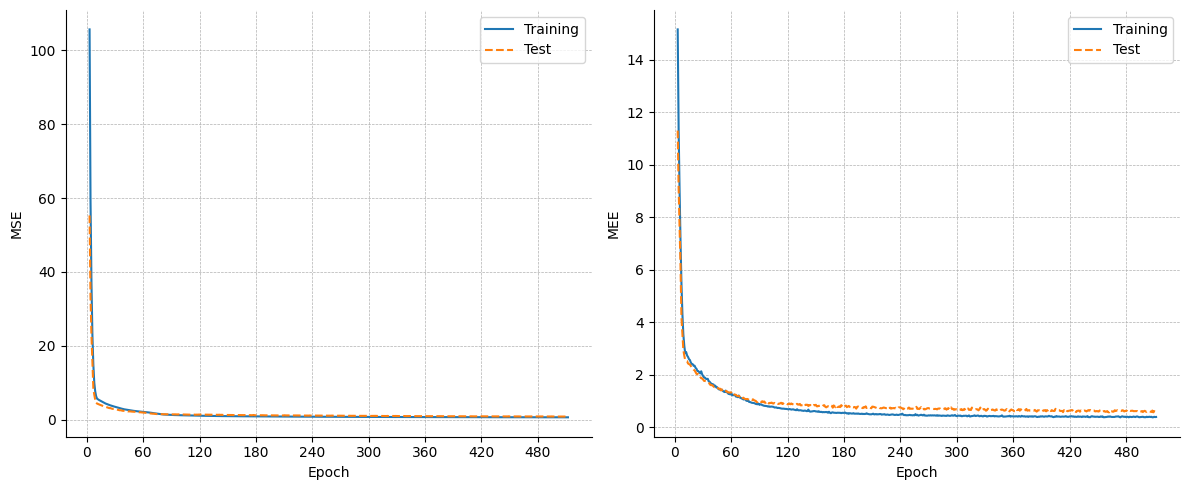

In [276]:
solver.plot_history(results_dir + '/CUP/history')

In [277]:
print('-- TRAINING --')
loss_train_cup, mee_train_cup = model_nn_cup.evaluate(x_train_cup, y_train_cup)
print(f'Loss (MSE): {loss_train_cup:.4f} -  MEE: {mee_train_cup:.4f}')

-- TRAINING --
29/29 [==============================] - 0s 1ms/step - loss: 0.6848 - mean_euclidean_error: 0.3589
Loss (MSE): 0.6848 -  MEE: 0.3589


In [278]:
print('-- INTERNAL TEST --')
loss_internal_test_cup, mee_internal_test_cup = model_nn_cup.evaluate(x_internal_test_cup, y_internal_test_cup)
print(f'Loss (MSE): {loss_internal_test_cup:.4f} -  MEE: {mee_internal_test_cup:.4f}')

-- INTERNAL TEST --
4/4 [==============================] - 0s 2ms/step - loss: 0.9064 - mean_euclidean_error: 0.5593
Loss (MSE): 0.9064 -  MEE: 0.5593


## Blind Test Predictions

In [279]:
# Blind test set predictions
nn_preds_cup = model_nn_cup.predict(x_test_cup)

29/29 [==============================] - 0s 893us/step


## Store Result

In [280]:
report_nn = {
    'train': {'mse': loss_train_cup, 'mee': mee_train_cup},
    #'val': {'mse': loss_val_cup, 'mee': mee_val_cup},
    'internal_test': {'mse': loss_internal_test_cup, 'mee': mee_internal_test_cup}
}

store_cup_result(results_dir + '/CUP/', best_config_cup,  report_nn, nn_preds_cup)